# 2. Source Detection and Aperture Photometry for Cropped Region 1

In this step, we will do the following items:
* Perform sources detection and extraction
* Perform aperture photometry process to measure fluxes and get the spectral energy distributions of the detected sources. 

We will do all of these processes using [SEP](https://sep.readthedocs.io/en/v1.0.x/index.html), which is a python version of [SExtractor](https://www.astromatic.net/software/sextractor/) ([Bertin & Arnouts 1996](https://ui.adsabs.harvard.edu/abs/1996A%26AS..117..393B/abstract)). 

**Our goal here is to produce a photometric catalog containing coordinates and the spectral energy distribution of detected objects in cropped region**.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

List input images along with the set of filters. The input images here are the results of the PSF matching we did in the Step 1.

In [2]:
# list of filters and their names
filters = ['jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f200w', 'jwst_nircam_f277w',
           'jwst_nircam_f356w', 'jwst_nircam_f444w']

# number of filters
nbands = len(filters)

# Wavelength of the filters
photo_wave = [11540.0, 15010.0, 19890.0, 27620.0, 35680.0, 44080.0]

# Names of science images
sci_img = ['psfmatch_crop1_ceers5_f115w_sci.fits.gz', 'psfmatch_crop1_ceers5_f150w_sci.fits.gz', 
           'psfmatch_crop1_ceers5_f200w_sci.fits.gz', 'psfmatch_crop1_ceers5_f277w_sci.fits.gz', 
           'psfmatch_crop1_ceers5_f356w_sci.fits.gz', 'crop1_ceers5_f444w_sci.fits.gz']

# Names of variance images
var_img = ['psfmatch_crop1_var_ceers5_f115w_err.fits.gz', 'psfmatch_crop1_var_ceers5_f150w_err.fits.gz', 
           'psfmatch_crop1_var_ceers5_f200w_err.fits.gz', 'psfmatch_crop1_var_ceers5_f277w_err.fits.gz', 
           'psfmatch_crop1_var_ceers5_f356w_err.fits.gz', 'crop1_var_ceers5_f444w_err.fits.gz']

# pixel scale of the images
pixsize = 0.03

## 2.1. Source Detection and Extraction

We will use SEP for detecting sources and get the segmentation maps of them. For this example, let's base our detection on F150W band.

In [5]:
import sep

# get data image
hdu = fits.open('psfmatch_crop1_ceers5_f150w_sci.fits.gz')
data_sci = hdu[0].data
hdu.close()

data_sci = data_sci.byteswap(inplace=True).newbyteorder()

# get variance image
hdu = fits.open('psfmatch_crop1_var_ceers5_f150w_err.fits.gz')
data_var = hdu[0].data
hdu.close()

data_var = data_var.byteswap(inplace=True).newbyteorder()
data_err = np.sqrt(data_var)

objects, segmap = sep.extract(data_sci, thresh=2.0, err=data_err, minarea=5, 
                      deblend_nthresh=32, deblend_cont=0.005, segmentation_map=True)

In [6]:
# Get number of detected objects
nobj = len(objects)
print (nobj)

488


### Show detected objects

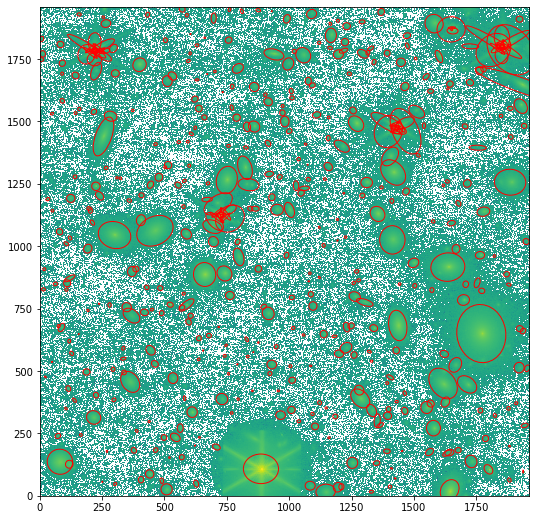

In [8]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(np.log10(data_sci), origin='lower')

# plot an ellipse for each object
for i in range(nobj):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i]*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


### Show segmentation maps

Segmentation map is a map showing the membership of pixels. Pixels belong to the same object will have the same value. This value is the index of the object in the SEP catalog. 

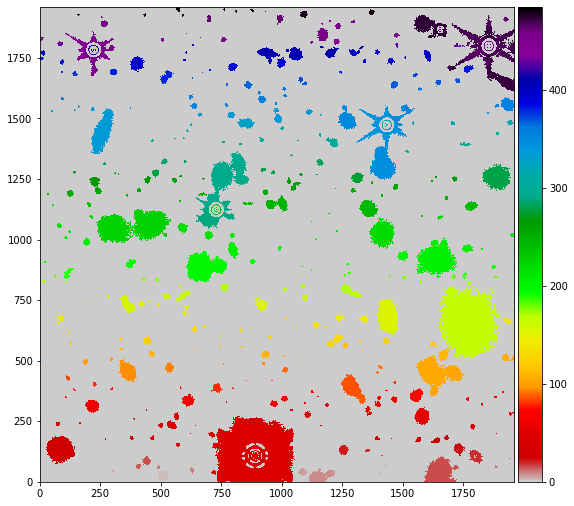

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(9,9))
f1 = plt.subplot()

im = plt.imshow(segmap, origin='lower', cmap='nipy_spectral_r')
divider = make_axes_locatable(f1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [10]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## 2.2. Aperture Photometry to get SEDs of detected objects

Spectral energy distribution (SED) is fluxes measured at multiple bands. In photometry, the SED can be regareded as spectrum with a very low spectral resolution.

For this tutorial, we will compute aperture photometry based on circular aperture with a radius of 10 pixels or 0.3 arcsec (in image with 0.03 arcsec/pixel).

In [7]:
# circular aperture radius
aper_radius = 10.0                     # in pixel (corresponds to 0.3 arcsec)

flux0 = np.zeros((nbands,nobj))
fluxerr0 = np.zeros((nbands,nobj))
flag0 = np.zeros((nbands,nobj))
for bb in range(0,nbands):
    hdu = fits.open(sci_img[bb])
    data_sci = hdu[0].data
    hdu.close()
    
    data_sci = data_sci.byteswap(inplace=True).newbyteorder()
    
    hdu = fits.open(var_img[bb])
    data_var = hdu[0].data
    hdu.close()
    
    data_var = data_var.byteswap(inplace=True).newbyteorder()
    data_err = np.sqrt(data_var)
    
    flux0[bb], fluxerr0[bb], flag0[bb] = sep.sum_circle(data_sci, objects['x'], objects['y'],
                                                 aper_radius, err=data_err, gain=1.0)
    
    # change nan or inf
    idx_ch = np.where(np.isnan(flux0[bb])==True)
    flux0[bb][idx_ch[0]] = -99.0
    
    idx_ch = np.where(np.isnan(fluxerr0[bb])==True)
    fluxerr0[bb][idx_ch[0]] = -99.0
  

In [8]:
# transpose from (band-id, obj-id) to (obj-id, band-id)
flux = np.transpose(flux0, axes=(1,0))
fluxerr = np.transpose(fluxerr0, axes=(1,0))
flag = np.transpose(flag0, axes=(1,0))

In [9]:
from astropy.table import QTable

fname = ['f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']

idx = np.arange(nobj)
data_table = []
names = []
data_table.append(idx)
names.append('ID')
data_table.append(objects['x'])
names.append('x')
data_table.append(objects['y'])
names.append('y')
for bb in range(0,nbands):
    data_table.append(flux0[bb])
    names.append('f_%s' % fname[bb])
    data_table.append(fluxerr0[bb])
    names.append('fe_%s' % fname[bb])
    
names = tuple(names)

t = QTable(data_table, names=names, meta={'name': 'catalog'})

In [10]:
t

ID,x,y,f_f115w,fe_f115w,f_f150w,fe_f150w,f_f200w,fe_f200w,f_f277w,fe_f277w,f_f356w,fe_f356w,f_f444w,fe_f444w
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,1329.7089662233716,15.907355695786759,1.9164379192749046,1.3914492644827792,2.7325598882275517,1.6625126297491943,2.814844624524849,1.68399612872437,2.9323740212037235,1.7134797119662615,2.7095321873272766,1.6466952358095999,2.08420336254887,1.4465228378751562
1,1403.9497163157687,35.905885644439564,1.6046766546619622,1.2746637583407074,1.901980941572583,1.3900275050793622,1.6173305195663128,1.2796039815322833,1.9139338102384982,1.3848026776608593,2.0945748062403435,1.447980844297277,1.8799223788518433,1.3742619390307331
2,508.64511579245743,25.386900555711996,15.32211773104966,3.917339578087571,33.59241703286767,5.799861619136852,40.825733638256786,6.392347770286098,51.278298347890384,7.161434692436191,59.58449071019889,7.71941954457319,62.3964996996522,7.899981066220578
3,302.7452392698023,46.79669784341222,1.5594026587405823,1.2571887126801093,2.025338014705921,1.4340062643146032,3.560106058978053,1.8925504261843917,3.440803801661823,1.8558113169893218,3.5797268095280743,1.892539718624896,3.2494942485950022,1.804703565539939
4,250.99783504805836,55.490318507478925,0.6115451045234295,0.7954524382740124,0.6030250992739276,0.7958077919499387,0.3694855214128622,0.6240995341784917,0.2968310098631854,0.5475539334986951,0.1750108352836736,0.42045821488217494,0.2166790084124659,0.47325186060862207
5,1084.1403277932159,39.98235629563253,13.866874118372797,3.7270779170223953,14.808871778026223,3.853026865583661,15.799683752730493,3.978170614830704,16.691574556902054,4.086153136607827,17.06652613811195,4.131515174018913,13.892529853321614,3.728203964861287
6,1209.2547873798455,35.72733107452523,5.564468452924048,2.3634468928051104,6.9061765293777,2.6342240872844225,7.003489645142107,2.650667066655845,7.09205086775124,2.6638620006778275,5.189711176929994,2.2785686846892412,4.326618037843145,2.0820952242396924
7,1194.6627764966631,33.79473880206992,8.82975573796779,2.9751685348295673,10.014888452105227,3.170115577384965,9.475596108548345,3.0820539785968797,8.548953613005574,2.924581208381786,5.83539325678721,2.41611494830877,4.708074045538406,2.1717309505644415
8,1146.077981670943,16.132876551408394,41.756060951352126,6.464214277933904,46.21004273504019,6.801637784077863,46.67821085184813,6.834945526926888,45.329452677071096,6.733298184746167,30.750309099704026,5.545624657551259,23.516725345551965,4.850438066223963


## 2.3. Convert surface brightness from MJy/sr to micro-Jy and erg/s/cm^2/A

JWST data units: MJy/sr

Mega Janskys (MJy); mag_AB = 8.9 - 2.5 log10(flux_Jy) = 31.4 - 2.5 log10(flux_nJy)

steradian (sr) = 4.255e+10 arcsec^2

In [11]:
arcsec2_per_sr = 4.25e+10
#sr_per_pix = sr_per_arcsec2*arcsec2_per_pix
sr_per_pix = pixsize*pixsize/arcsec2_per_sr

## convert to uJy
flux_uJy = flux*sr_per_pix*1e+12
fluxerr_uJy = fluxerr*sr_per_pix*1e+12

## convert to erg/s/cm^2
flux_ergscmA = flux_uJy*1e-6*1.0e-23*2.998e+18/photo_wave/photo_wave
fluxerr_ergscmA = fluxerr_uJy*1e-6*1.0e-23*2.998e+18/photo_wave/photo_wave

## 2.4. Calculate AB magnitudes

In [12]:
# AB magnitude
mag_AB = 8.9 - 2.5*np.log10(flux_uJy*1e-6)

# AB magnitude uncertainty
mag_AB_err = 2.5*np.log10(1 + fluxerr/flux)

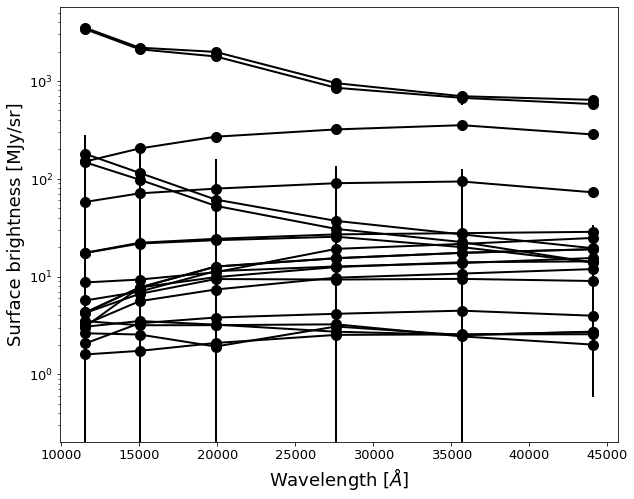

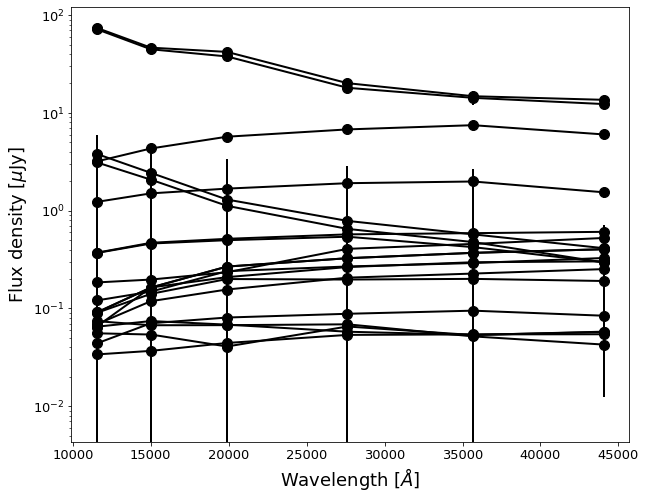

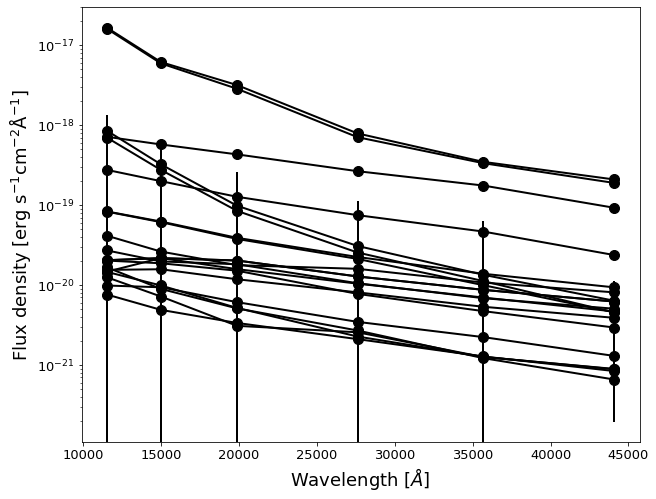

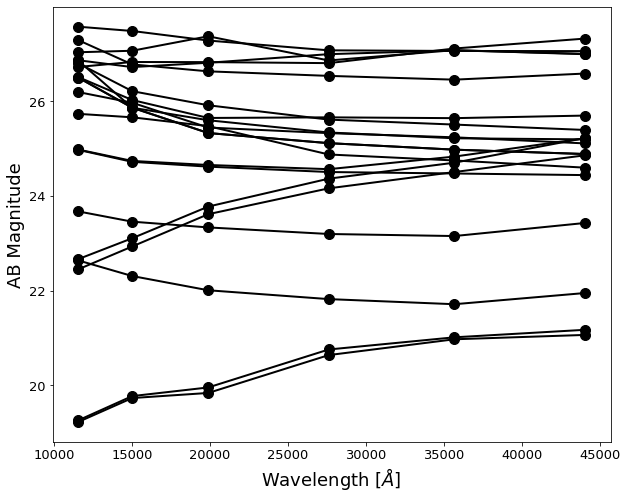

In [13]:
# choose 20 random objects
idx = np.random.randint(0,nobj-1,20)


# plot SED in surface brightness unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Surface brightness [MJy/sr]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux[idx[ii]], yerr=fluxerr[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in flux density (micro Jy) unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Flux density [$\mu$Jy]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux_uJy[idx[ii]], yerr=fluxerr_uJy[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in flux density (erg/s/cm^2/A) unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Flux density [erg $\rm{ s}^{-1}\rm{cm}^{-2}\AA^{-1}$]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux_ergscmA[idx[ii]], yerr=fluxerr_ergscmA[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in AB magnitude
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"AB Magnitude", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, mag_AB[idx[ii]], yerr=fluxerr_ergscmA[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()

## 2.5. Make photometric catalog

We will store results of our aperture photometry into a catalog named `ceers_crop1_photo.cat`. We will also include the coordinates of the galaxies. Since we only have cartesian coordinates from SEP, we need to convert those back into the sky coordinates.

In [14]:
# Get sky coordinates of the detected objects
from astropy.wcs import WCS

hdu = fits.open('psfmatch_crop1_ceers5_f150w_sci.fits.gz')
wcs = WCS(hdu[0].header)
hdu.close()

obj_ra, obj_dec = wcs.wcs_pix2world(objects['x'], objects['y'], 1)

In [15]:
# make photometric catalog: flux in erg/s/cm^2/A
file_out = open("ceers_crop1_photo.cat","w")
file_out.write("#(1)id (2)x (3)y (4)ra (5)dec (6)f_f115w (7)e_f115w (8)f_f150w (9)e_f150w (10)f_f200w (11)e_f200w (12)f_f277w (13)e_f277w (14)f_f356w (15)e_f356w (16)f_f444w (17)e_f444w \n")
file_out.write("# All flux densisties are in units of erg/s/cm^2/Angstrom \n")
for ii in range(0,nobj):
    file_out.write("%d %lf %lf %lf %lf " % (ii+1,objects['x'][ii],objects['y'][ii],obj_ra[ii],obj_dec[ii]))
    for bb in range(0,nbands-1):
        file_out.write("%e %e " % (flux_ergscmA[ii][bb],fluxerr_ergscmA[ii][bb]))
    file_out.write("%e %e\n" % (flux_ergscmA[ii][int(nbands)-1],fluxerr_ergscmA[ii][int(nbands)-1]))

file_out.close()

## 2.6. Make input photometric catalog for photometric redshift with EAZY

In this step, we prepare an input catalog for performing photometric redshift using EAZY software.

In [16]:
file_out = open('ceers_eazy_input_crop1.cat', 'w')
file_out.write('#id f_f115w e_f115w f_f150w e_f150w f_f200w e_f200w f_f277w e_f277w f_f356w e_f356w f_f444w e_f444w z_spec\n')
file_out.write('#id F364 E364 F365 E365 F366 E366 F375 E375 F376 E376 F377 E377 z_spec\n')

for ii in range(0,nobj):
    file_out.write("%d  " % (ii+1))
    for bb in range(0,nbands):
        file_out.write("%e  %e  " % (flux_uJy[ii][bb],fluxerr_uJy[ii][bb]))
    file_out.write("-1.000\n")

file_out.close()